In [1]:
!pip install pickle5 pandas==1.3 wandb torchinfo torchviz
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image
from torchinfo import summary
from torchviz import make_dot
import wandb

from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler

from random import randint
from google.colab import drive
import pickle5 as pickle
import warnings

from IPython.display import Image
from IPython.core.display import Image, display

import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2


In [2]:
# Load Data
def load_data():

  drive.mount('/content/drive')
  local_path = 'drive/My Drive/deep_learning/assignment/datasets/'
  #local_path = "C:/Users/simon/Nextcloud2/Master/Deep Learning/assignment/"
  data_path = local_path + "dataset_big_boi_unscaled.pickle"

  with open(data_path, "rb") as fh:
    dataset = pickle.load(fh)
  return dataset

In [3]:
def build_model(channel_multiplier,device,kernel_size_1,kernel_size_2,kernel_size_3,pool_size):

  class Model(nn.Module):
      def __init__(self,channel_multiplier,kernel_size_1,kernel_size_2,kernel_size_3,pool_size):
          super(Model, self).__init__()
          self.channel_multiplier = channel_multiplier
          self.pool_size = pool_size
          self.kernel_size_1 = kernel_size_1
          self.kernel_size_2 = kernel_size_2
          self.kernel_size_3 = kernel_size_3

          self.conv1 = nn.Sequential(
              nn.Conv1d(1,2*self.channel_multiplier,self.kernel_size_1),
              nn.ReLU())
          self.conv2 = nn.Sequential(
              nn.Conv1d(2*self.channel_multiplier,4*self.channel_multiplier,self.kernel_size_2),
              nn.ReLU())
          self.conv3 = nn.Sequential(
              nn.Conv1d(4*self.channel_multiplier,8*self.channel_multiplier,self.kernel_size_3),
              nn.ReLU())
          self.conv4 = nn.Sequential(
              nn.Conv1d(8*self.channel_multiplier,8*self.channel_multiplier,kernel_size=5,padding="same"),
              nn.ReLU())
          
          self.pool = nn.MaxPool1d(self.pool_size,return_indices=True)
          self.unpool = nn.MaxUnpool1d(self.pool_size)

          self.deconv1 = nn.Sequential(
              nn.ConvTranspose1d(8*self.channel_multiplier,4*self.channel_multiplier,self.kernel_size_3),
              nn.ReLU())
          self.deconv2 = nn.Sequential(
              nn.ConvTranspose1d(4*self.channel_multiplier,2*self.channel_multiplier,self.kernel_size_2),
              nn.ReLU())
          self.deconv3 = nn.Sequential(
              nn.ConvTranspose1d(2*self.channel_multiplier,1,self.kernel_size_1))
          
      def forward(self, x):
          #print(x.shape)
          x = self.conv1(x)
          out_1 = x.size()
          x, indices1 = self.pool(x)
          x = self.conv2(x)
          out_2 = x.size()
          x, indices2 = self.pool(x)
          x = self.conv3(x) 
          #out_3 = x.size()       
          #x, indices3 = self.pool(x)
          #x = self.conv4(x)
          #x = self.unpool(x, indices3,output_size=out_3)
          x = self.deconv1(x)
          x = self.unpool(x, indices2,output_size=out_2)
          x = self.deconv2(x)
          x = self.unpool(x, indices1,output_size=out_1)
          x = self.deconv3(x)
          #print(x.shape)
          return x

  return Model(channel_multiplier,kernel_size_1,kernel_size_2,kernel_size_3,pool_size).to(device)


In [4]:
def build_dataset(batch_size,max_iri_value,small=False):
  #if "dataset" not in globals():
  print("Loading Dataset")
  dataset = load_data()

  data_shape_old = dataset["train"].shape
  train_set_l = dataset["train"][["z","IRI_mean"]].drop(dataset["train"][["z","IRI_mean"]][dataset["train"]["IRI_mean"]>max_iri_value].index)
  print(f"Shape of dataset: {data_shape_old}, after max iri: {train_set_l.shape}")
  train_set_high_iri = dataset["train"][["z","IRI_mean"]].drop(dataset["train"][["z","IRI_mean"]][dataset["train"]["IRI_mean"]<=max_iri_value].index)
  train_set = train_set_l["z"].values
  test_set = dataset["test"]["z"].values
  print(f"Dataset length reduced: {dataset['train'].shape[0]} -> {train_set.shape[0]}")
  return dataset, train_set, test_set,train_set_high_iri

In [5]:
def train_epoch(epoch, model, train_set, test_set, optimizer, loss_function, device, batch_size):
  train_loss = 0
  test_loss = 0
  rng = np.random.default_rng(epoch)
  rng.shuffle(train_set,axis=0)
  rng.shuffle(test_set, axis=0)

  model.train()
  for idx in range(train_set.shape[0]//batch_size):
      batch = np.zeros((batch_size,1,train_set[0].shape[0]))
      for b in range(batch_size):
        batch[b][0]=train_set[idx*batch_size+b]

      batch = torch.from_numpy(batch).to(device).float()
      output = model(batch)
      loss = loss_function(output, batch)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      train_loss += loss.item()


  model.eval()
  with torch.no_grad():
    for idx in range(test_set.shape[0]//batch_size):
        batch = np.zeros((batch_size,1,test_set[0].shape[0]))
        for b in range(batch_size):
            batch[b]=test_set[idx*batch_size+b]
        batch = torch.from_numpy(batch).to(device).float()
        output = model(batch)
        loss = loss_function(output, batch)
        test_loss += loss.item()

  train_loss = train_loss/(train_set.shape[0]//batch_size)
  test_loss = test_loss/(test_set.shape[0]//batch_size)
  return train_loss, test_loss

def build_optimizer(model,learning_rate):
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 
  loss_function = torch.nn.MSELoss()
  return optimizer,loss_function

def print_model(model,train_set,device):
  print(f"Actual Input shape: {train_set[0].reshape(1,1,-1).shape}, actual output shape: {model(torch.from_numpy(train_set[0].reshape(1,1,-1)).to(device).float()).shape}")
  print(summary(model, train_set[0].reshape(1,1,-1).shape))


In [6]:
def show_reconstr_images(batch_size,train_set,test_set,model,device,sweep,n_images=2):
  for i in range(n_images):
    train_batch = np.zeros((batch_size,1,test_set[0].shape[0]))
    test_batch = np.zeros((batch_size,1,train_set[0].shape[0]))
    r = np.random.randint(0,300)

    #for b in range(batch_size):
    #  train_batch[b]=train_set[r+b]
    #  test_batch[b]=test_set[r+b]

    print(train_set.shape)
    train_out = model(torch.from_numpy(train_set[r].reshape(1,1,-1)).to(device).float()).cpu().detach().numpy()
    test_out = model(torch.from_numpy(test_set[r].reshape(1,1,-1)).to(device).float()).cpu().detach().numpy()
    fig, (ax1, ax2) = plt.subplots(ncols=2,figsize=(26,8))

    ax1.plot(train_out[0][0],c="r",label="reconstruction")
    ax1.plot(train_set[r],c="b",label="input")
    ax1.set_title("Test data")
    ax1.legend()

    ax2.plot(test_out[0][0],c="r",label="reconstruction")
    ax2.plot(test_set[r],c="b",label="input")
    ax2.set_title("Train data")
    ax2.legend() 
    if sweep: 
      wandb.log({"Reconstruction_on_random_indice: " + str(r): wandb.Image(fig)})
      plt.close()


In [7]:
def fit_classifier(test_loss_log,max_iri_value,test_set_extended):

  clf = make_pipeline(StandardScaler(),
                    LinearSVC(random_state=0, tol=1e-5,max_iter=1e5))
  X = np.array(test_loss_log).reshape(-1,1)
  y = [0 if v<max_iri_value else 1 for v in test_set_extended["IRI_mean"].values]
  clf.fit(X, y)
  score = clf.score(X, y)
  preds = clf.predict(X)
  print(f"Linear SVM accuracy: {score*100:.2f}%")
  print(preds)
  return score,preds


In [8]:
def loss_visualisation(model,loss_function,device,dataset,train_set_high_iri,loss_cutoff,max_iri_value):

  test_loss_log,is_outlier = [],[]
  nm_tp,nm_fp = 0,0
  #test_set_ext = dataset["test"][["z","IRI_mean"]].append(train_set_high_iri).sort_values(by='IRI_mean')
  test_set_ext = dataset["test"][["z","IRI_mean"]].sort_values(by='IRI_mean')

  test_ins = test_set_ext["z"].values
  

  for i in range(test_ins.shape[0]):
    
    test_in = torch.from_numpy(test_ins[i].reshape(1,1,-1)).to(device).float()
    model.eval()
    with torch.no_grad():
      test_out = model(test_in)
      loss = loss_function(test_out,test_in).item()
    test_loss_log.append(loss)


  score, predictions = fit_classifier(test_loss_log,max_iri_value,test_set_ext)
  with warnings.catch_warnings():
    warnings.filterwarnings('ignore', r'All-NaN (slice|axis) encountered')

  mean_losses_100, mean_losses_10 = [],[]
  for i in range(0,100,1):
    mean_losses_100.append(np.array(test_loss_log)[np.where((dataset["test"]["IRI_mean"]>i*0.1) & (dataset["test"]["IRI_mean"]<=i*0.1+0.1))[0]].mean())
  for i in range(10):
    mean_losses_10.append(np.array(test_loss_log)[np.where((dataset["test"]["IRI_mean"]>i) & (dataset["test"]["IRI_mean"]<=i+1))[0]].mean())

  fig, (ax1, ax2, ax3) = plt.subplots(ncols=3,figsize=(26,8))
  ax1.plot([max_iri_value]*2,(np.nanmin(mean_losses_100),np.nanmax(mean_losses_100)),c="g")
  #ax1.scatter(np.linspace(0,9.9,100),mean_losses_100)
  ax1.plot(mean_losses_10,c="b")
  ax1.set_ylabel("mse loss avg")
  ax1.set_xlabel("IRI mean")
  ax1.set_title("mean losses over IRI mean with iri cutoff line (green)")
  ax2.hist(test_set_ext["IRI_mean"])
  ax2.set_title("IRI mean distribution over test set")

  ax3.scatter(test_set_ext["IRI_mean"],test_loss_log,c=predictions)
  ax3.set_title(f"Predictions for LinearSVC with accuracy: {score*100:.1f}%")
  ax3.set_ylabel("MSE loss")
  ax3.set_xlabel("IRI mean")
  ax3.plot([max_iri_value]*2,(np.nanmin(test_loss_log),np.nanmax(test_loss_log)),c="g")


In [9]:
def train(config=None,sweep=True):
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

  if sweep:
    with wandb.init(config):    
      config = wandb.config

      model = build_model(config.channel_multiplier,
                          device,
                          config.kernel_size_1,
                          config.kernel_size_2,
                          config.kernel_size_3,
                          config.pool_size)
      
      dataset, train_set, test_set, train_set_high_iri = build_dataset(config.batch_size,
                                                                      config.max_iri_value,
                                                                      small=False)
      
      optimizer, loss_function = build_optimizer(model, config.learning_rate)
      print_model(model,train_set,device)

      for epoch in range(config.epochs):
        train_loss, test_loss = train_epoch(epoch,
                                            model,
                                            train_set,
                                            test_set,
                                            optimizer,
                                            loss_function,
                                            device,
                                            config.batch_size)
        
        wandb.log({"loss":test_loss,"epoch": epoch})     

        if epoch%10==0:
          print("Epoch: [{}/{}] Train-Loss: {:.3f}, Val-Loss: {:.3f}".format(epoch+1, 
                                config.epochs, train_loss, test_loss))
      show_reconstr_images(config.batch_size,
                    train_set,
                    test_set,
                    model,
                    device,
                    sweep,
                    n_images=1,
                    )
  
      loss_visualisation(model,
                        loss_function,
                        device,
                        dataset,
                        train_set_high_iri,
                        config.loss_cutoff,
                        config.max_iri_value)
  if not sweep:
    config_ = {}
    for key in config["parameters"].keys():
        config_.update({key:config["parameters"][key]["value"]})
    config = config_

    model = build_model(config["channel_multiplier"],
                      device,
                      config["kernel_size_1"],
                      config["kernel_size_2"],
                      config["kernel_size_3"],
                      config["pool_size"])
  
    dataset, train_set, test_set, train_set_high_iri = build_dataset(config["batch_size"],
                                                                    config["max_iri_value"],
                                                                    small=False)
    
    optimizer, loss_function = build_optimizer(model, config["learning_rate"])
    print_model(model,train_set,device)

    for epoch in range(config["epochs"]):
      train_loss, test_loss = train_epoch(epoch,
                                          model,
                                          train_set,
                                          test_set,
                                          optimizer,
                                          loss_function,
                                          device,
                                          config["batch_size"])
      
      print("Epoch: [{}/{}] Train-Loss: {:.3f}, Val-Loss: {:.3f}".format(epoch+1, 
                            config["epochs"], train_loss, test_loss))
    show_reconstr_images(config["batch_size"],
                        train_set,
                        test_set,
                        model,
                        device,
                        sweep,
                        n_images=2)
    loss_visualisation(model,
                      loss_function,
                      device,
                      dataset,
                      train_set_high_iri,
                      config["loss_cutoff"],
                      config["max_iri_value"])
    
    







In [10]:

sweep_config = {
    'method': 'random'
    }

sweep_config['metric'] = {
    'name': 'loss',
    'goal': 'minimize'   
    }

sweep_config["early_terminate"] = {
  "type": "hyperband",
  "min_iter": 5
}

#max IRI value is INCLUDED in training

sweep_config['parameters'] = {
    'channel_multiplier': {
        'value': 8
        },
    'batch_size': {
        'value': 32
        },
    'learning_rate': {
          'value': 1e-4
        },
    'epochs': {
          'value': 50
        },
    'pool_size': {
          'value': 5
        },
    'kernel_size_1': {
          'value': 5
        },
    'kernel_size_2': {
          'value': 5
        },
    'kernel_size_3': {
          'value': 5
        },
    'max_iri_value': {
          'value': 5
        },
    'loss_cutoff': {
          'value': 0.02
        },
    }


Loading Dataset
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Shape of dataset: (2752, 6), after max iri: (2439, 2)
Dataset length reduced: 2752 -> 2439
Actual Input shape: (1, 1, 3085), actual output shape: torch.Size([1, 1, 3085])
Layer (type:depth-idx)                   Output Shape              Param #
Model                                    --                        --
├─Sequential: 1-1                        [1, 16, 3081]             --
│    └─Conv1d: 2-1                       [1, 16, 3081]             96
│    └─ReLU: 2-2                         [1, 16, 3081]             --
├─MaxPool1d: 1-2                         [1, 16, 616]              --
├─Sequential: 1-3                        [1, 32, 612]              --
│    └─Conv1d: 2-3                       [1, 32, 612]              2,592
│    └─ReLU: 2-4                         [1, 32, 612]              --
├─MaxPool1d: 1-4                         [1, 3

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: Mean of empty slice.


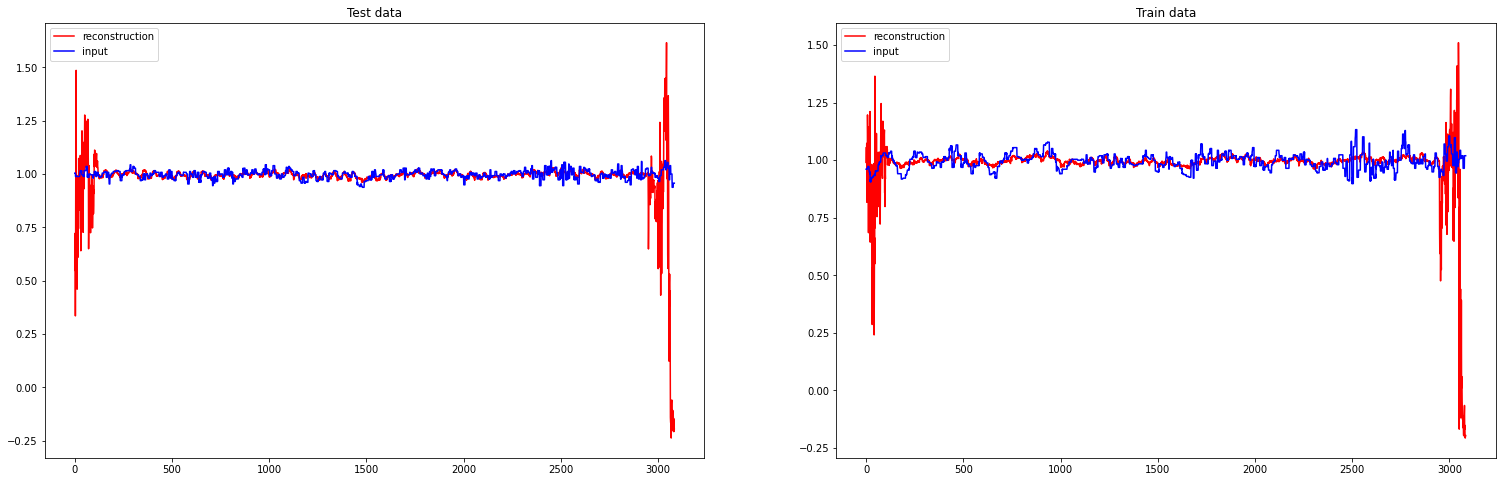

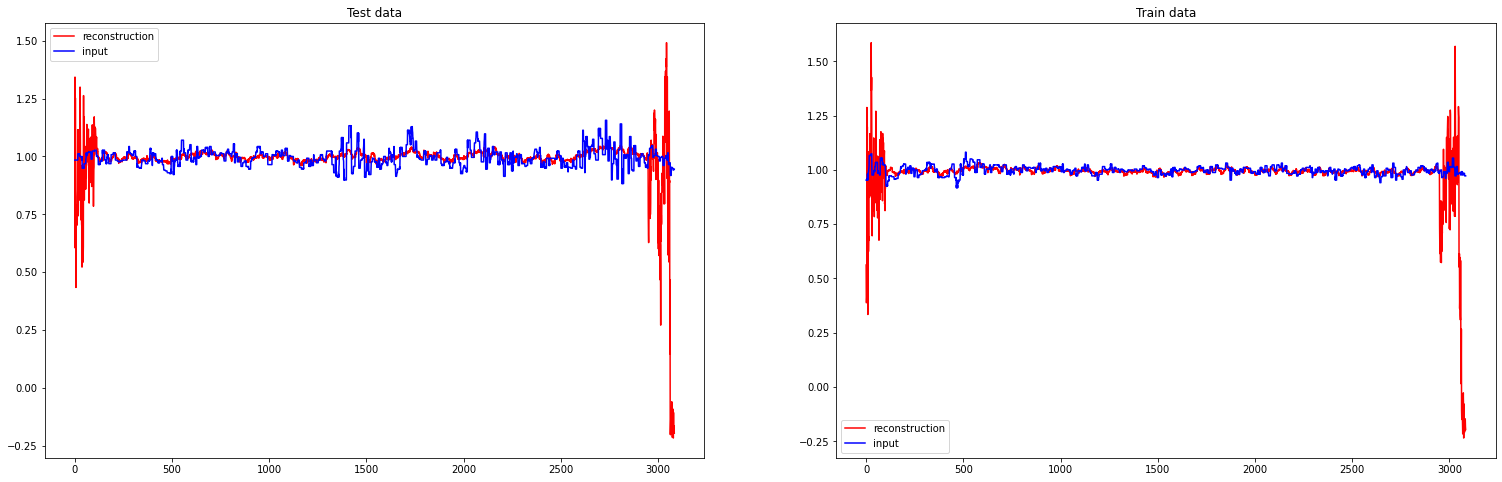

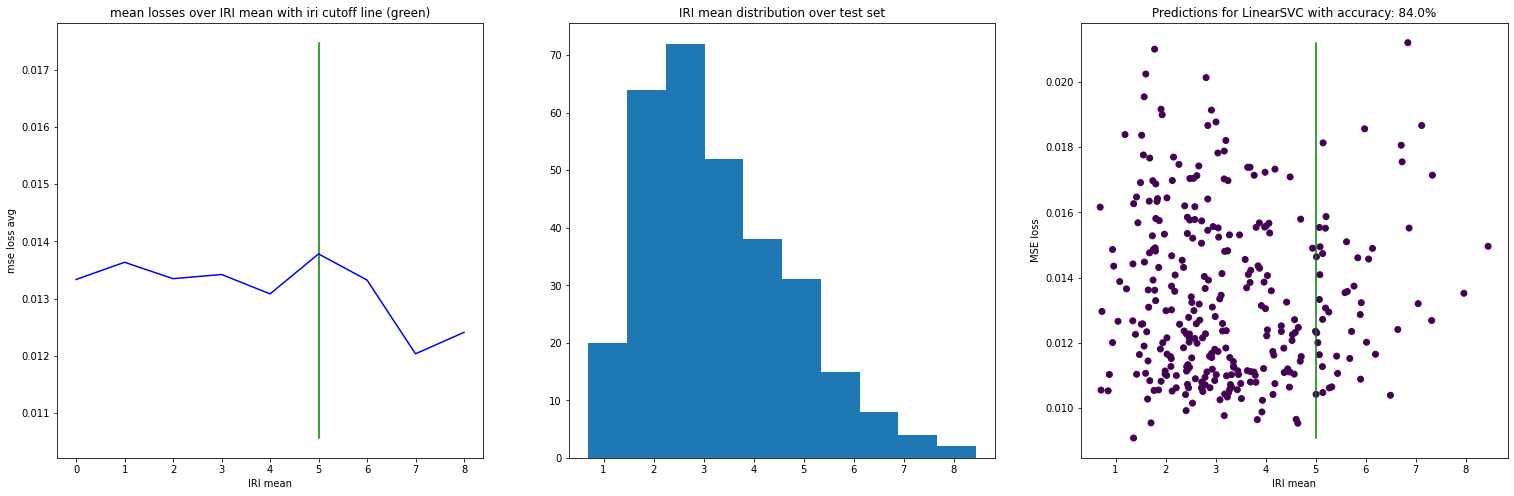

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
config_ = {}
sweep=False
for key in sweep_config["parameters"].keys():
    config_.update({key:sweep_config["parameters"][key]["value"]})
config = config_

model = build_model(config["channel_multiplier"],
                  device,
                  config["kernel_size_1"],
                  config["kernel_size_2"],
                  config["kernel_size_3"],
                  config["pool_size"])

dataset, train_set, test_set, train_set_high_iri = build_dataset(config["batch_size"],
                                                                config["max_iri_value"],
                                                                small=False)

optimizer, loss_function = build_optimizer(model, config["learning_rate"])
print_model(model,train_set,device)

for epoch in range(config["epochs"]):
  train_loss, test_loss = train_epoch(epoch,
                                      model,
                                      train_set,
                                      test_set,
                                      optimizer,
                                      loss_function,
                                      device,
                                      config["batch_size"])
  
  print("Epoch: [{}/{}] Train-Loss: {:.3f}, Val-Loss: {:.3f}".format(epoch+1, 
                        config["epochs"], train_loss, test_loss))
show_reconstr_images(config["batch_size"],
                    train_set,
                    test_set,
                    model,
                    device,
                    sweep,
                    n_images=2)
loss_visualisation(model,
                  loss_function,
                  device,
                  dataset,
                  train_set_high_iri,
                  config["loss_cutoff"],
                  config["max_iri_value"])

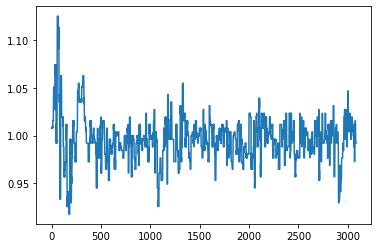

In [12]:
plt.plot(train_set[0])

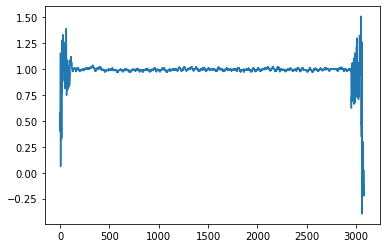

In [13]:
plt.plot(model(torch.from_numpy(train_set[0].reshape(1,1,-1)).to(device).float()).cpu().detach().numpy()[0][0])

In [14]:
#train(sweep_config,False)

In [15]:
#!wandb login
#sweep_id = wandb.sweep(sweep_config, project="ae-sweep2")
#wandb.agent(sweep_id, train, count=30)